In [46]:
import pandas as pd
import yfinance as yf
import numpy as np

In [47]:
ticker = 'mc.bk'
data = yf.Ticker(ticker)
print(data.info)

currentprice = data.info['currentPrice']
sector = data.info['sector']
print(currentprice)
print(sector)

dr = 0.10
gr = 0.10
tgr = 0.03
year_growth = 3
year_sustain = 7
growth_to_sustain_ratio = 0.5

{'address1': 'No. 448, 450 On Nut Road', 'address2': 'Prawet Sub-District Prawet District', 'city': 'Bangkok', 'zip': '10250', 'country': 'Thailand', 'phone': '66 2 329 1050', 'fax': '66 2 727 7289', 'website': 'https://www.mcgroupnet.com', 'industry': 'Apparel Manufacturing', 'industryKey': 'apparel-manufacturing', 'industryDisp': 'Apparel Manufacturing', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': 'MC Group Public Company Limited, together with its subsidiaries, manufactures, distributes, and retails apparel, accessories, and lifestyle products in Thailand. The company offers ready-to-wear clothing and apparels. It also offers bags, belts, and activewears. In addition, the company offers skincare and aromatic products. Further, it manages PCs and warehouse employees; and distributes products and services through online/internet channel, as well as manages trade and products. The company markets its product

In [48]:
# data.cash_flow.index

In [49]:
### - get > Average Free cash flow , shares , Net Debt = Long Term Borrowings - Cash ###

## Shares ## 
shares = data.info['sharesOutstanding']
print('Ticker = ',ticker,' Shares = ',shares)

## Net Debt = Long Term Borrowings - Cash ###
if sector == 'Financial Services':
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Net Debt'].values[0][0]
else:
    totalnoncurrentliabilities = data.balancesheet.loc[data.balancesheet.index == 'Total Non Current Liabilities Net Minority Interest'].values[0][0] - data.balancesheet.loc[data.balancesheet.index == 'Cash And Cash Equivalents'].values[0][0]

print('Ticker = ',ticker,' Net Debt = ',totalnoncurrentliabilities)

## Average Free Cash Flow ## 
year = 4
if sector == 'Financial Services':
    averagefreecashflow = (data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year].mean()
    print((data.cash_flow.T['Free Cash Flow'] + data.cash_flow.T['Repayment Of Debt']).dropna()[:year])
else:
    averagefreecashflow = data.cash_flow.T['Free Cash Flow'].dropna()[:year].mean()
    print(data.cash_flow.T['Free Cash Flow'].dropna()[:year])


print('Ticker = ',ticker,'Average Free Cash Flow = ',averagefreecashflow)

Ticker =  mc.bk  Shares =  792000000
Ticker =  mc.bk  Net Debt =  585472590.0
2024-06-30    835796648.0
2023-06-30    335877861.0
2022-06-30    825461008.0
2021-06-30    722702497.0
Name: Free Cash Flow, dtype: object
Ticker =  mc.bk Average Free Cash Flow =  679959503.5


In [50]:
##### Create a DCF Function ######

def intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    return (np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares

print(ticker + ' Intrinsic Value = ',
      np.round(intrinsic_value(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        gr
        ),2))

mc.bk Intrinsic Value =  15.97


In [51]:
### Put current price as a target ### 

def intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        gr
        ):
    
    PV_1 = [averagefreecashflow * ((1+gr)**i) / ((1+dr)**i) for i in range(1,year_growth+1,1)]
    PV_2 = [averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**i)/((1+dr)**(year_growth+i)) for i in range(1,year_sustain+1,1)]
    TV = averagefreecashflow * ((1+gr)**year_growth) * ((1+(gr*growth_to_sustain_ratio))**(year_sustain)) * (1+tgr) / ((dr-tgr)*((1+dr)**(year_growth+year_sustain)))
    # print((((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares)) , currentprice)
    return (((np.sum(PV_1) + np.sum(PV_2) + TV - totalnoncurrentliabilities)/shares) - currentprice)/currentprice

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        0.15
        )*100," % ")

67.78251092954355  % 


In [52]:
def newton_raphson_method(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice):
    
    initial_guess = 0.01
    tolerance = 0.01
    max_iterations = 100000
    x_n = initial_guess
    
    for iteration in range(max_iterations):
    # while (True):
        f_x = intrinsic_value_diff_currentprice(
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice,
            x_n
        )

        if abs(f_x) < tolerance :
            break

        x_n = x_n - f_x * 0.01

    return x_n

In [53]:
root = newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice)

print("Estimated GR:", root)

print(intrinsic_value_diff_currentprice(
        shares,
        totalnoncurrentliabilities,
        averagefreecashflow,
        year_growth,
        year_sustain,
        growth_to_sustain_ratio,
        dr,
        tgr,
        currentprice,
        root
        ) * 100," % ")


Estimated GR: 0.04823745715195677
-0.9982487270851252  % 


      growthrate
0.04   -0.242603
0.05   -0.152330
0.06   -0.093857
0.07   -0.048647
0.08   -0.010905
0.09    0.018616
0.10    0.048237
0.11    0.075653
0.12    0.101239
0.13    0.125396
0.14    0.148536
0.15    0.170729
0.16    0.192111
0.17    0.212890
0.18    0.233154
0.19    0.252973
0.20    0.272304
0.21    0.291395
0.22    0.310086
0.23    0.328512
0.24    0.346699
0.25    0.364675
0.26    0.382458
0.27    0.400068
0.28    0.417421
0.29    0.434731
0.30    0.451909
2.3433934518234913 -0.21202689928568305


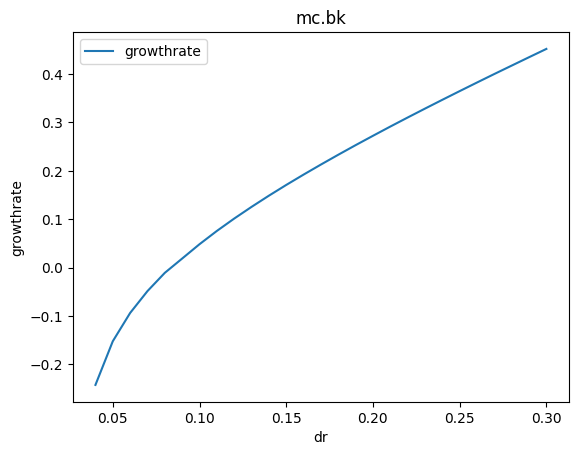

In [ ]:
dr_list = [dr*0.01 for dr in range(int((tgr*100)+1),101,1)]
df = pd.DataFrame(index=dr_list,columns=['growthrate'])

growthrate = [ newton_raphson_method(           
            shares,
            totalnoncurrentliabilities,
            averagefreecashflow,
            year_growth,
            year_sustain,
            growth_to_sustain_ratio,
            dr,
            tgr,
            currentprice) for dr in dr_list]
df['growthrate'] = growthrate
print(df)
df.plot(xlabel='dr', ylabel='growthrate').set_title(ticker)

beta, alpha = np.polyfit(np.array(df.index).astype('float64'), np.array(df['growthrate']).astype('float64'),1)
print(beta,alpha)